# TPC2 -  Sistemas de Equações

<ul>
    <li>Não deve escrever o seu nome nem nenhum código identificador em nenhum sítio. </li>
    <li>Deve entregar ESTE Notebook de Jupyter.</li>
    <li>O trabalho é individual. Podem e devem haver discussões com colegas mas o resultado entregue é individual. </li>
    <li>Não deve acrescentar ou apagar nenhuma célula. </li>
    <li>Todas as explicações devem ser claras e concisas. </li>
    <li>É preferível fazer menos e fazer bem que muito e mal. </li>
    <li>O método @jit(nopython=True) do pacote numba pode diminuir o tempo de cálculo.</li>
    <li>A não verificação de alguma destas regras leva ao anulamento e exclusão da prova.</li>
</ul>


In [1]:
# Código Geral
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Palete de cores para os gráficos
palete = list(colors.TABLEAU_COLORS.values())


# NOTA: Este Jupyter foi criado usando VSCode! Se algum do LaTeX não for mostrado corretamente, por favor abra o notebook em VSCode!

# Sistema de massas livre
Considere um sistema de $N$ massas acopladas entre si e a duas paredes
fixas com $N+1$ molas:

\begin{equation}
m\frac{d^{2}X_{i}}{dt^{2}}=-k_{i}\left(X_{i}-X_{i-1}\right)+k_{i+1}\left(X_{i+1}-X_{i}\right)
\end{equation}
onde $X_{0}=0$ e $X_{N+1}=L$. Podemos usar como unidades de comprimento
a distância entre as paredes, a massa $m$ e como unidade de tempo
\begin{equation}
\tau=\sqrt{\frac{m}{\overline{k}}}
\end{equation}
onde $\overline{k}$ a constante média das molas.

1. Escreva uma rotina que resolva um sistema de equações usando uma eliminação
de Gauss com pivotagem parcial.

A eliminação de Gauss já é um algoritmo nosso conhecido. Para fazer a pivotagem parcial, vou usar um mapa de endereços para evitar copiar desncessariamente linhas da matriz. O mapa de endereços `mm` usado é um array onde o `i`-ésimo elemento guarda a posição na matriz original da linha que após as trocas está na posição `i`.

Por exemplo, se `mm[2] = 4` a 2ª linha da matriz após as trocas é igual à 4ª linha da matriz antes das trocas.

Deste modo podemos aceder à linha `i` da matriz após as trocas acedendo à linha `mm[i]` da matriz antes das trocas!

In [2]:
def gausselim(Ao: np.ndarray, bbo: np.ndarray) -> np.ndarray:
    """
        Resolve o sistema de N equações definido por Ao * xx = bbo usando eliminação gaussiana com pivotagem parcial.

        ### Argumentos
        Ao: Matriz N por N
        bbo: Vetor com N entradas
        
        ### Retorno
        xx: Vetor com N entradas
    """

    # Evitar side effects
    A = np.copy(Ao)
    bb = np.copy(bbo)

    N = bb.size

    # Fazer pivotagem usando um mapa de endereços
    mm = np.arange(0, N)
    for linha in range(N):
        # Posição do maior elemento da coluna (tendo em conta as trocas já feitas)
        coluna = abs(A[mm[linha:], linha])
        index = list(coluna).index(max(coluna)) + linha

        # Trocar os elementos
        mm[linha], mm[index] = mm[index], mm[linha]

    # Eliminação Gaussiana
    for i in range(N-1):
        piv = A[mm[i]][i]
        for j in range(i+1, N):
            coef = A[mm[j]][i] / piv
            A[mm[j]] -= A[mm[i]] * coef
            bb[mm[j]] -= bb[mm[i]] * coef

    # Substituição Regressiva
    xx = np.zeros(N)
    xx[-1] = bb[mm[-1]] / A[mm[N-1]][N-1]
    for i in range(N-1, -1, -1):
        xx[i] = (bb[mm[i]] - (A[mm[i]][i+1:] @ xx[i+1:])) / A[mm[i]][i]
    
    return xx

2. Considerando massas iguais e molas iguais,

    (a) Em que condições o sistema está em equilíbrio? Resolva o correspondente sistema de equações e obtenha as posições de equilíbrio ($X_{i}^{eq}$).

Podemos escrever as equações que descrevem o sistema como:

$$
\begin{align*}
\begin{cases}
m_1\frac{d^2X_1}{dt^2} = -k_1X_1 + k_2(X_2-X_1)
\\[0.2cm]
\vdots
\\[0.2cm]
m_i\frac{d^2X_i}{dt^2} = -k_i(X_i-X_{i-1}) + k_{i+1}(X_{i+1}-X_i)
\\[0.2cm]
\vdots
\\[0.2cm]
m_N\frac{d^2X_N}{dt^2} = -k_N(X_N-X_{N-1}) + k_{N+1}(L-X_N)
\end{cases}
\end{align*}
$$

O sistema apenas está em repouso se a força total exercida em cada massa for nula (caso contrário irá haver movimento). Usando a segunda lei de Newton, $F = ma$, percebemos que isso acontece quando o lado esquerdo das equações acima for nulo.

Então, no caso em que todas as massas são iguais e todas as molas são iguais com constante de mola igual a $k$, podemos escrever o seguinte sistema de equações (onde já dividimos ambos os lados da equação por $k$):

$$
\begin{align*}
\begin{cases}
-2X_1 + X_2 = 0
\\[0.2cm]
\vdots
\\[0.2cm]
-2X_i + X_{i-1} + X_{i+1} = 0
\\[0.2cm]
\vdots
\\[0.2cm]
-2X_N + X_{N-1} = -L
\end{cases}
\end{align*}
$$

Percebemos desde já que este sistema de equações lineares é possível e determinado, uma vez que não conseguimos escrever nenhuma das equações como uma combinação linear das outras.

Olhando para as primeiras equações parace que uma solução é $X_i = iX_1$. Vamos tentar provar por indução que assim é para as primeiras $N-1$ equações:
- Para $i = 1$ a solução é válida
- Para $i = 2$ a solução é válida pela primeira equação do sistema: $X_2 = 2X_1$
- Para $i+1$ podemos verificar que a solução se mantém válida se já o for para $i-1$ e para $i$:
$$
\begin{align*}
-2X_i + X_{i-1} + X_{i+1} = 0 &\Leftrightarrow -2iX_1 + (i-1)X_1 + X_{i+1} = 0
\\[0.3cm]
&\Leftrightarrow X_{i+1} = X_1(2i - (i-1))
\\[0.3cm]
&\Leftrightarrow X_{i+1} = (i+1)X_1
\end{align*}
$$

Basta agora verificar se esta solução também satisfaz a última equação! Para o fazer vamos supor que $X_N = NX_1$ e averiguar se há algum valor de $X_1$ que seja solução da equação:
$$
\begin{align*}
-2X_N + X_{N-1} = -L &\Leftrightarrow X_1(-2N + N - 1) = -L
\\[0.4cm]
&\Leftrightarrow X_1(N+1) = L
\\[0.3cm]
&\Leftrightarrow X_{1} = \frac L{N+1}
\end{align*}
$$

Ou seja, encontramos uma solução do sistema de equações! Como o sistema é possível e determinado, encontramos **a** solução do sistema:
$$
X_i = \frac{iL}{N+1}
$$

Podemos agora verificar numericamente esta solução para alguns valores de $N$, resolvendo o sistema de equações usando eliminação gaussiana com pivotagem!

**Nota**: Usou-se $L=1$.

In [3]:
def unbandify(B: np.ndarray, up: int, down: int) -> np.ndarray:
    """
        Dada uma matriz B (up + down + 1) por N que já foi organizada como descrito nas páginas 524-525 do Newman, devolve a matriz quadrada correspondente.

        ### Argumentos
        B: Matriz para transformar
        down: Número de subdiagonais não nulas abaixo da diagonal principal
        up: Número de subdiagonais não nulas acima da diagonal principal
        
        ### Retorno
        A: Matriz N por N
    """

    N = B.shape[1]
    A = np.zeros((N, N))

    # Percorre as linhas de B e guarda-as nas diagonais de A
    for line in range(up + down + 1):
        start = max(0, up - line)
        end = min(N, N + up - line)

        diag = up - line
        for i in range(0, end-start):
            A[max(0, -diag) + i, max(0, diag) + i] = B[line, i+start]
    
    return A


def eqs1(N: int, ki: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
        Devolve a matriz A e o vetor b que define o problema 1 na forma A * x = b.

        ### Argumentos
        N: Número de equações
        ki: Array com os valores de ki escolhidos
    
        ### Retorno
        Ab: Matriz A em banda 3 por N (na forma descrita nas páginas 524-525 do Newman)
        bb: Vetor com N entradas
    """

    # Subdiagonal superior
    upper = ki[1:N]

    # Diagonal principal
    diag = - ki[:N] - ki[1:]

    # Subdiagonal inferior
    lower = ki[1:N]

    # Matriz em banda
    Ab = np.zeros((3, N))
    Ab[0, 1:] = upper
    Ab[1] = diag
    Ab[2, :N-1] = lower

    # Vetor b
    bb = np.zeros(N)
    bb[N-1] = - ki[-1]

    return Ab, bb


# Parâmetros
eps = 1e-12  # Tolerância para considerarmos que se verifica a solução


# Tentar alguns Ns aleatórios
for _ in range(5):
    N = np.random.randint(10, 200)
    ki = np.ones(N + 1)

    # Gerar o problema
    Ab, bb = eqs1(N, ki)
    A = unbandify(Ab, 1, 1)

    # Resolver
    xx = gausselim(A, bb)

    # Comparar com a solução prevista
    pp = np.arange(1, N+1) / (N+1)
    
    xx /= pp
    for item in xx:
        if abs(1 - item) > eps:
            print(f"Diferença relativa maior que {eps:.0e} para N = {N:<3}.")
            break
    else:
        print(f"A solução foi verificada para N = {N:<3} com tolerância de {eps:.0e}.")

A solução foi verificada para N = 27  com tolerância de 1e-12.
A solução foi verificada para N = 130 com tolerância de 1e-12.
A solução foi verificada para N = 60  com tolerância de 1e-12.
A solução foi verificada para N = 40  com tolerância de 1e-12.
A solução foi verificada para N = 20  com tolerância de 1e-12.


(b) Verifique que no equilíbrio as distâncias entre massas são sempre iguais e iguais a $1/(N+1)$.

Em equilíbrio, todas as massas estão em repouso, pelo que as suas posições são constantes. Como tal, as distâncias entre as massas são também constantes ao longo do tempo.

Usando a solução obtida acima e escolhendo $L=1$, conseguimos verificar que a distância entre massas consecutivas é sempre igual e igual a $1/(N+1)$:
$$
\begin{align*}
X_{i+1} - X_i &= \frac{i+1}{N+1} - \frac{i}{N+1}
\\[0.4cm]
&= \frac{1}{N+1}
\end{align*}
$$

In [4]:
# Parâmetros
eps = 1e-12  # Tolerância para considerarmos que se verifica a solução


# Tentar alguns Ns aleatórios
for _ in range(5):
    N = np.random.randint(10, 200)
    ki = np.ones(N + 1)

    # Gerar o problema
    Ab, bb = eqs1(N, ki)
    A = unbandify(Ab, 1, 1)

    # Resolver
    xx = gausselim(A, bb)

    # Distâncias entre massas consecutivas em equilíbrio
    dd = xx[1:] - xx[:N-1]

    # Comparar com a solução prevista
    pp = np.ones(N - 1) / (N + 1)
    
    dd /= pp
    for item in dd:
        if abs(1 - item) > eps:
            print(f"Diferença relativa maior que {eps:.0e} para N = {N:<3}.")
            break
    else:
        print(f"A solução foi verificada para N = {N:<3} com tolerância de {eps:.0e}.")

A solução foi verificada para N = 158 com tolerância de 1e-12.
A solução foi verificada para N = 83  com tolerância de 1e-12.
A solução foi verificada para N = 48  com tolerância de 1e-12.
A solução foi verificada para N = 97  com tolerância de 1e-12.
A solução foi verificada para N = 174 com tolerância de 1e-12.


3. Gere aleatoriamente valores de $k_{i}$ usando uma distribuição gaussiana
de largura $\sigma=0.1$ e valor médio $\mu=1$. Faça um histograma
das diferenças entre as posições de equilíbrio de massas consecutivas
para um sistema com $N=2^{10}$.

## Equacionar o Problema

O sistema de equações que temos de resolver para encontrar as posições de equilíbrio é obtido de um modo semelhante ao que vimos acima, sendo que agora os $k_i$ são em geral diferentes:
$$
\begin{align*}
\begin{cases}
-(k_1+k_2)X_1 + k_2X_2 = 0
\\[0.2cm]
\vdots
\\[0.2cm]
-(k_i+k_{i+1})X_i + k_iX_{i-1} + k_{i+1}X_{i+1} = 0
\\[0.2cm]
\vdots
\\[0.2cm]
-(k_N + k_{N+1})X_N + k_NX_{N-1} = -k_{N+1}
\end{cases}
\end{align*}
$$

Onde consideramos de novo $L = 1$. Podemos escrever este sistema na forma $AX = b$, onde:
- $A$ é a matriz $N \times N$ tridiagonal abaixo:
$$
A = \begin{pmatrix}
- k_1 - k_2 & k_2 & 0 & \dots& 0 & 0 & 0
\\[0.2cm]
k_2 & -k_2 - k_3 & k_3 & \dots& 0 & 0 & 0
\\[0.2cm]
0 & k_3 & -k_3 - k_4 & \dots& 0 & 0 & 0
\\[0.2cm]
\vdots & \vdots & \vdots & \ddots& \vdots& \vdots & \vdots
\\[0.2cm]
0 & 0 & 0 & \dots & -k_{N-2} - k_{N-1} & k_{N-1} & 0
\\[0.2cm]
0 & 0 & 0 & \dots & k_{N-1} & -k_{N-1} - k_N & k_{N}
\\[0.2cm]
0 & 0 & 0 & \dots & 0 & k_N & -k_{N} - k_{N+1}
\end{pmatrix}
$$

- $X$ é o vetor das incógnitas:
$$
X = \begin{pmatrix}
X_1
\\[0.2cm]
X_2
\\[0.2cm]
\vdots
\\[0.2cm]
X_{N-1}
\\[0.2cm]
X_N
\\[0.2cm]
\end{pmatrix}
$$

- $b$ é o seguinte vetor:
$$
b = \begin{pmatrix}
0
\\[0.2cm]
0
\\[0.2cm]
\vdots
\\[0.2cm]
0
\\[0.2cm]
-k_{N+1}
\\[0.2cm]
\end{pmatrix}
$$

Para encontrar as posições de equilíbrio podemos então resolver este sistema. Vamos fazê-lo usando dois métodos:
- Eliminação de Gauss com pivotagem, definida no exercício 1.1
- Eliminação de Gauss sem pivotagem tirando partido do facto de $A$ ser uma matriz em banda tridiagonal, definida abaixo


Podemos ainda comparar a distância média entre molas consecutivas com a distância média caso todos os $k_i$ sejam iguais, que vimos acima que é dada por:
$$
d = \frac{1}{N+1}
$$


## Analisar os Resultados
Notamos que, para $N$ suficientemente elevado, a média das distância entre molas conscutivas aproxima-se de $d$! Isto é interessante, sendo que parece apenas ser consequência do facto de os $k_i$ terem sido escolhidos de modo aleatório e de modo a que estejam todos num intervalo relativamente pequeno (numa dada amostra, praticamente todos os $k_i$ vão-se encontrar em, por exemplo, $\mu \pm 5\sigma$).

Observamos também que a distribuição de distâncias entre molas não é claramente uma distribuição normal, não sendo sequer simétrica.

A linha a amarelo corresponde à média das distâncias de equilíbrio.
A linha a vermelho corresponde à distância de equilíbrio caso todos os ki sejam iguais, determinada acima como 1/(N+1).

Os gráficos da esquerda foram obtido usando eliminação gaussiana sem pivotagem e tirando partido do facto de a matriz ser em banda.
Os gráficos da direita foram obtido usando eliminação gaussiana com pivotagem.

No caso de discrepâncias o código com pivotagem oferece resultados de maior confiança.


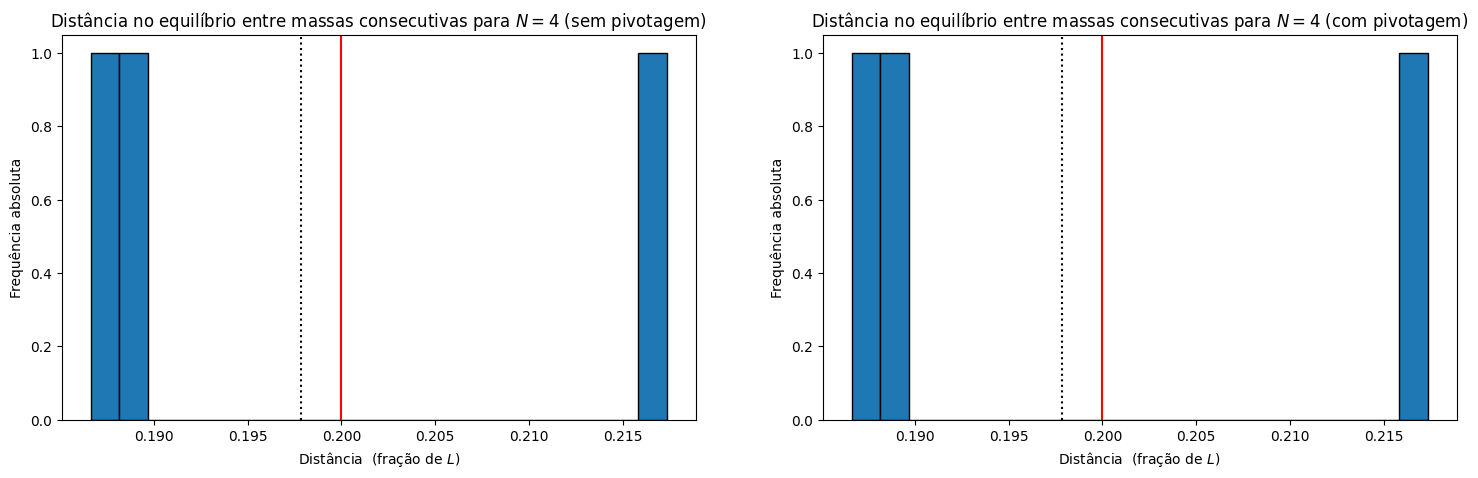

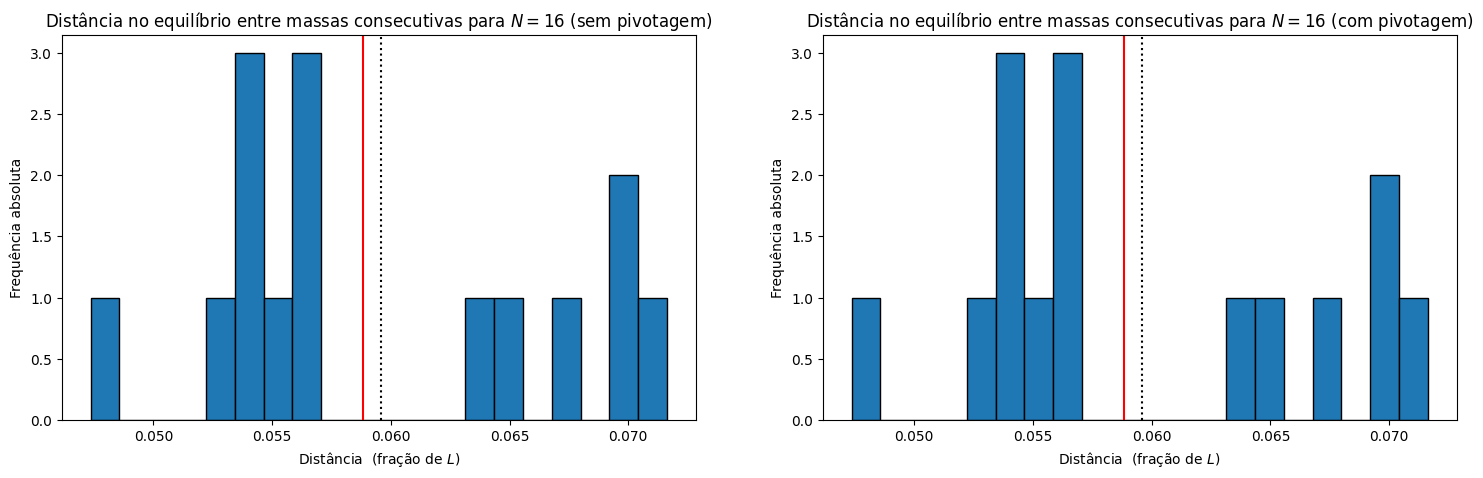

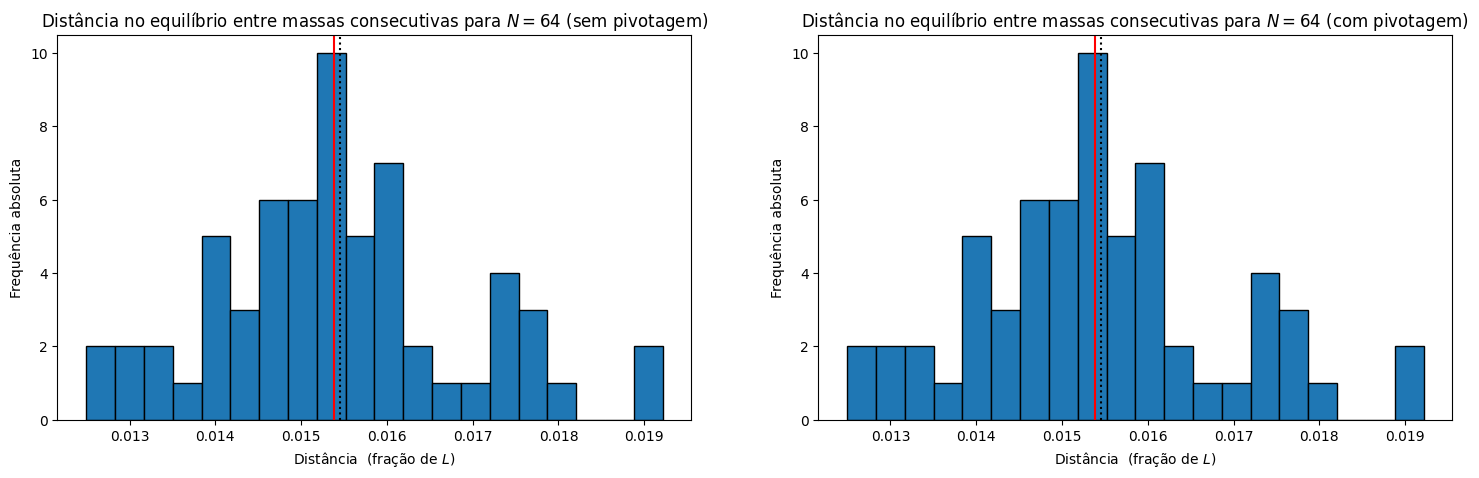

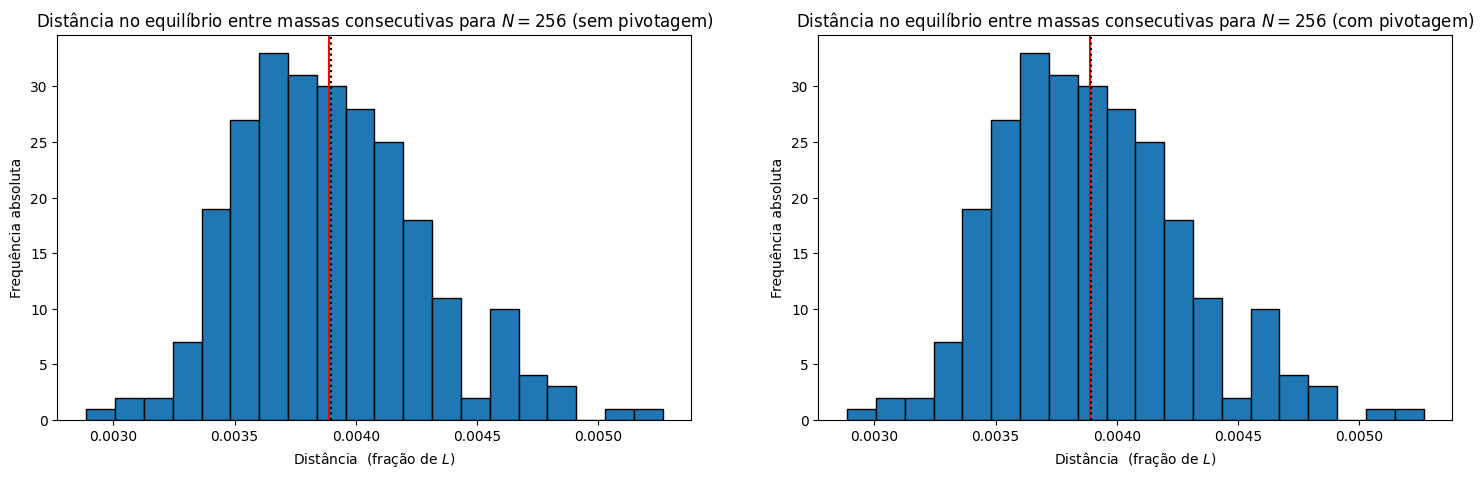

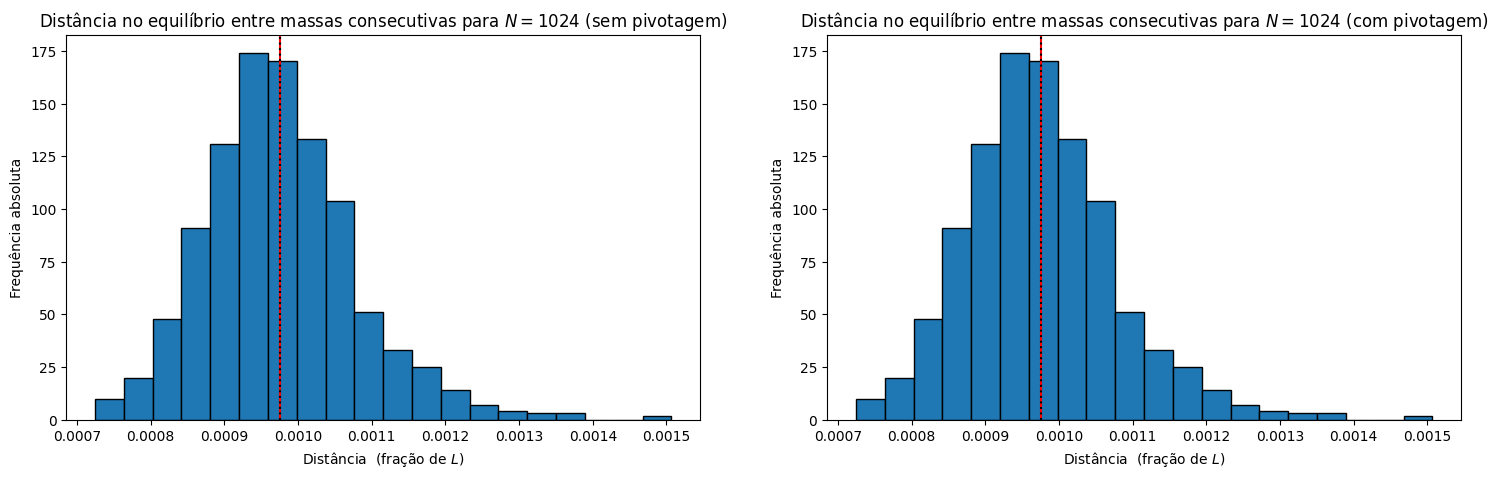

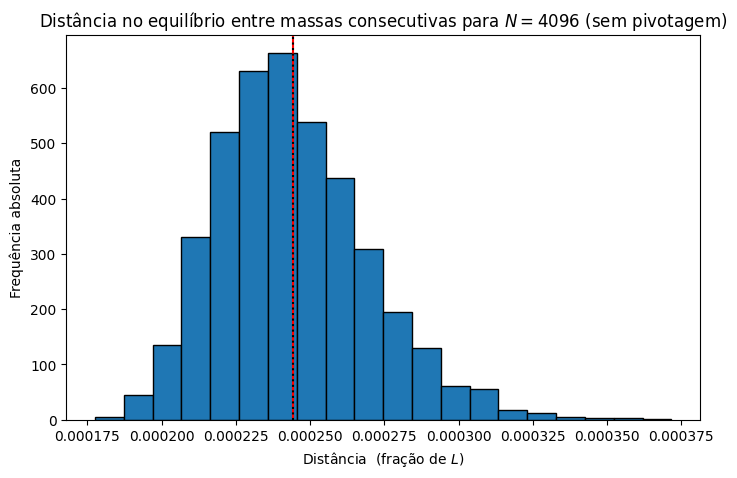

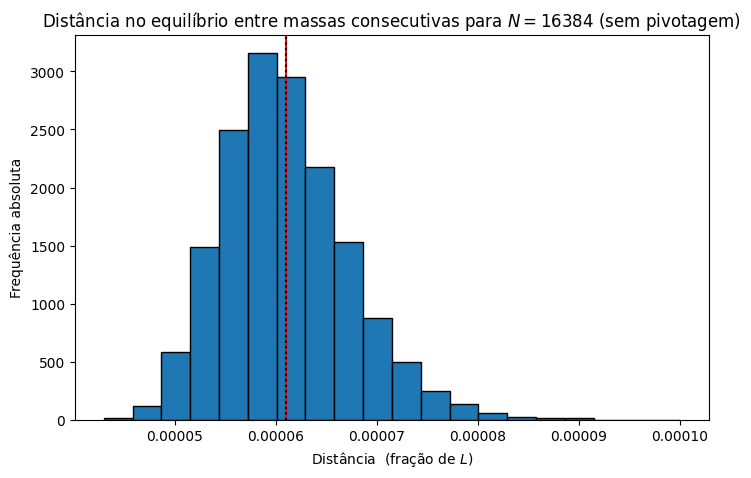

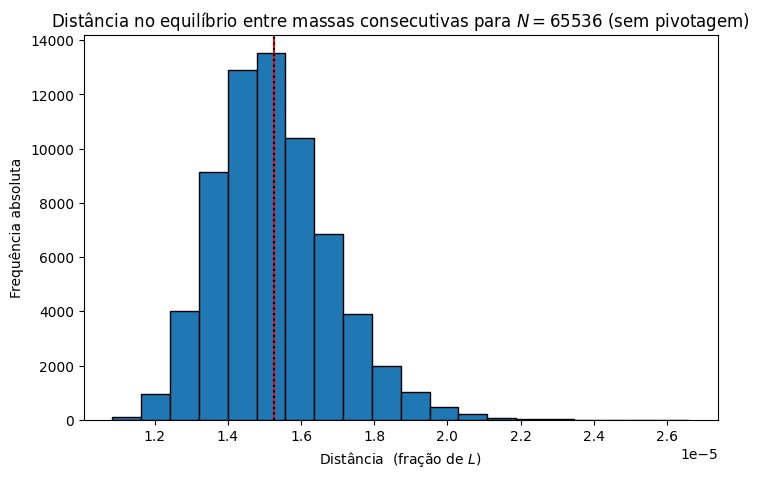

In [5]:
def gaussbanded(Ao: np.ndarray, bbo: np.ndarray, up: int, down: int) -> np.ndarray:
    """
        Resolve o sistema de equações definido por A * xx = bb usando eliminação gaussiana sem pivotagem, sendo A uma matriz em banda na forma definida nas páginas 524-525 do Newman.
    """

    # Evitar side effects
    A = np.copy(Ao)
    bb = np.copy(bbo)

    N = bb.size

    # A matriz ainda não é triangular superior
    if down != 0:

        # Eliminação Gaussiana
        for i in range(N-1):

            # O pivô apenas anda para o lado na matriz A
            piv = A[up, i]

            # Percorrer as linhas de A, que correspondem a diagonais da esquerda para a direita e de baixo para cima na matriz em banda
            for j in range(1, min(down + 1, N-i)):
                coef = A[up + j, i] / piv
                bb[j + i] -= bb[i] * coef
                
                # Percorrer os elementos desta linha da matriz A e atualizar a matriz de acordo com o algoritmo da eliminação de Gauss

                # Chegamos ao fim da linha quando tivermos percorrido (ver definições abaixo):
                    # up + down + 1 elementos
                    # line <= 0 (o elemento em line = 0 só tem zeros acima, pelo que não precisa de ser atualizado)
                    # col >= N 

                # Resolvendo estas condições obtemos este mínimo
                fim = min(up + down + 1, up + j, N - i)
                for k in range(fim):
                    line = up + j - k
                    col = i + k
                    
                    A[line, col] -= A[up - k, i + k] * coef

    # Substituição Regressiva
    xx = np.zeros(N)
    xx[-1] = bb[-1] / A[up, N-1]
    for i in range(N-1, -1, -1):

        # Determinar A[i, i+1:] @ xx[i+1:] tirando proveito do facto de A ser em banda (ver programa usual de eliminação de Gauss)
        prod = 0

        # Usamos o mesmo algoritmo que acima, mas agora com j = 0 e com line >= 0 em vez de line <= 0
        fim = min(up+1, N - i)
        for k in range(1, fim):
            line = up - k
            col = i + k

            # Corresponde a A[i, i + k] * xx[i + k] se A não fosse bandified
            prod += A[line, col] * xx[i + k]

        xx[i] = (bb[i] - prod) / A[up, i]
    
    return xx


def problema(N: int, ki: np.ndarray, banda: bool=False) -> None:
    """
        Define e resolve o problema acima usando eliminação gaussiana

        ### Argumentos
        N: Número de equações
        ki: Array com os valores de ki escolhidos
        banda: Resolver só usando o facto de o problema ser definido usando uma matriz em banda ou não
    
        ### Retorno
        None
    """

    Ab, bb = eqs1(N, ki)

    # Variáveis que vão ser definidas abaixo
    text = ""
    dd = np.array([])

    plt.figure(figsize=(18, 5))
    for metodo in [1, 2]:
        if metodo == 1:
            text = "sem pivotagem"

            # Posições em equilíbrio
            xx = gaussbanded(Ab, bb, 1, 1)

            # Diferenças entre posições das massas em equilíbrio (espaçamentos)
            dd = xx[1:] - xx[:N-1]
        
        elif metodo == 2 and (not banda):
            text = "com pivotagem"

            # Transformar A numa matriz quadrada
            A = unbandify(Ab, 1, 1)

            # Posições em equilíbrio
            xx = gausselim(A, bb)

            # Diferenças entre posições das massas em equilíbrio (espaçamentos)
            dd = xx[1:] - xx[:N-1]

        if (metodo == 1) or (metodo == 2 and (not banda)):
            # Representação gráfica
            plt.subplot(1, 2, metodo)
            plt.hist(dd, edgecolor="black", bins=20)
            plt.title(f"Distância no equilíbrio entre massas consecutivas para $N = {N}$ ({text})")
            plt.xlabel(f"Distância  (fração de $L$)")
            plt.ylabel("Frequência absoluta")

            # Linha vertical em x = 1/(N+1) (caso em que todos os ki são iguais)
            plt.axvline(1/(N+1), color="red")

            # Linha vertical na média de ee
            plt.axvline(dd.mean(), color="black", linestyle='dotted')

    plt.show()

    return None


# Parâmetros
NN = 2**np.arange(2, 18, 2)


print("A linha a preto corresponde à média das distâncias de equilíbrio.")
print("A linha a vermelho corresponde à distância de equilíbrio caso todos os ki sejam iguais, determinada acima como 1/(N+1).")
print("")
print("Os gráficos da esquerda foram obtido usando eliminação gaussiana sem pivotagem e tirando partido do facto de a matriz ser em banda.")
print("Os gráficos da direita foram obtido usando eliminação gaussiana com pivotagem.")
print("")
print("No caso de discrepâncias o código com pivotagem oferece resultados de maior confiança.")

for N in NN:
    # Gerar os ki aleatoriamente
    ki = np.random.normal(1, 0.1, N + 1)

    problema(N, ki, N > 2000)

4. Fazendo a mudança de variável, $x_{i}=X_{i}-X_{i}^{eq}$ podemos transformar
o sistema de equações diferenciais em,
\begin{equation}
\frac{d^{2}x_{i}}{dt^{2}}=A_{ij}x_{j}\qquad\text{com }1\le i\le N
\end{equation}
onde é usada a convenção de índices repetidos e a matriz $A$ é simétrica
e tridiagonal.

(a) Note que sabendo os valores próprios do sistema de $A$, $\lambda_{\beta}$, e os respectivos vectores próprios $v_{i}^{\beta}$ (devidamente normalizados $\sum_{i}v_{i}^{\beta}v_{i}^{\alpha}=\delta_{\alpha\beta}$), podemos construir um novo conjunto de variáveis,\begin{equation}f_{\beta}=U_{\beta i}^{T}x_{i} \end{equation} onde $U$ é uma matriz ortogonal com os vectores próprios, $v_{i}^{\beta},$em cada coluna e $U^{T}$ é a sua transposta ($U_{j\alpha}U_{\alpha i}=\delta_{ji}$).
Note-se ainda, que 
\begin{equation}
\sum_{i,j}U_{\beta i}^{T}A_{ij}U_{j\alpha}=D_{\alpha\beta}
\end{equation}
onde $D$ é a matriz diagonal com os valores, $D_{\alpha\alpha}=\lambda_{\alpha}$.
Fazendo a mudança de coordenadas associada a esta transformação ortogonal,
obtemos o seguinte sistema equivalente
\begin{align*}
\frac{d^{2}f_{\beta}}{dt^{2}} & =D_{\beta\alpha}f_{\alpha}.
\end{align*}
Como $D$ é diagonal as equações desacoplam, i.e.
\begin{equation}
\frac{d^{2}f_{\beta}}{dt^{2}}=\lambda_{\beta}f_{\beta},
\end{equation}
que admitem soluções da forma
\begin{equation}
f_{\beta}=A_{\beta}e^{t\sqrt{\lambda_{\beta}}}+B_{\beta}e^{-t\sqrt{\lambda_{\beta}}}
\end{equation}
Logo a diagonalização da matriz $A$ permite a solução do sistema
de equações no tempo. Utilize a decomposição $QR$ para obter, quer
os valores próprios, quer os vectores próprios de uma matriz com $k_{i}$
aleatórios como descrito anteriormente ( $N=10$).

Vamos usar decomposição de Gram-Schmidt para obter a decomposição QR da matriz diagonal $A$. Usando a decomposição QR repetidamente conseguimos obter os valores e vetores próprios de $A$.

Notamos que a solução só é oscilatória se os autovalores forem negativos (para que as exponenciais sejam complexas). Verificamos que isto de facto acontece!

---

Podemos ainda notar que $f_\beta$ corresponde às coordenadas normais do sistema, já que:
- Permitem desacoplar as equações que descrevem a sua dinâmica.

- O valor de $f_\beta$ apenas tem uma frequência associada: $\omega_\beta = \sqrt{|\lambda_\beta|}$ (usamos o módulo pois $\lambda_\beta < 0$).

In [6]:
def qrgram(Ao: np.ndarray, needR: bool=True) -> tuple[np.ndarray, np.ndarray]:
    """
        Dado uma matriz quadrada Ao calcula a sua decomposição QR usando o método de Gram-Schmidt.
        
        ### Argumentos
        Ao: Matriz a decompor
        needR: Calcula R se needR = True

        ### Retorno
        Q: Matriz Q da decomposição QR
        R: Matriz R da decomposição QR (caso needR=False devolve uma matriz com zeros)
    """

    # Evitar side effects
    A = np.copy(Ao)

    N = A.shape[0]
    Q, R = np.zeros((N, N)), np.zeros((N, N))
    
    # Iteramos sobre as colunas
    for i in range(0, N):
        v_i = np.copy(A[:, i])
        for j in range(0, i):
            v_i -= (Q[:, j] @ A[:, i]) * Q[:, j]

        Q[:, i] = v_i / np.linalg.norm(v_i)

    if needR:
        R = Q.transpose() @ A
    
    return Q, R


def eigenfinder(Ao: np.ndarray, eps: float=1e-06) -> tuple[np.ndarray, np.ndarray]:
    """
        Devolve os autovalores e autovetores de uma matriz Ao simétrica usando decomposição QR iterada.
        Termina quando a soma dos valores absolutos dos elementos fora da diagonal for menor que eps.
        
        ### Argumentos
        Ao: Matriz simétrica N por N cujos autovalores e autovetores queremos obter
        eps: Erro máximo permitido

        ### Retorno
        eigenvalues: Array com os N autovalores
        eigenvectors: Matriz N por N cujas colunas são os respetivos autovetores normalizados
    """

    # Evitar side-effects
    A = np.copy(Ao)
    N = A.shape[0]

    # Registar os autovalores
    QTotal = np.identity(N)

    # Executar um passo da iteração
    erro = eps + 1
    while erro > eps:
        Q, R = qrgram(A, needR=False)

        A = Q.transpose() @ A @ Q
        QTotal = QTotal @ Q

        # Somar o módulo dos items fora da diagonal principal
        erro = np.sum(np.abs(A)) - np.sum([np.abs(A[i][i]) for i in range(A.shape[0])])
    
    eigenvalues = np.diag(A)
    eigenvectors = QTotal

    # Normalizar os autovetores
    for i in range(N):
        eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])

    return eigenvalues, eigenvectors


# Parâmetros
N = 10
ki = np.random.normal(1, 0.1, N + 1)


# Gerar a matriz do problema
Ab, bb = eqs1(N, ki)
A = unbandify(Ab, 1, 1)

lamb, U = eigenfinder(A)

# Verificar os autovetores
for i in range(A.shape[0]):
    res = A @ U[:, i]

    print(f"{lamb[i]:.4f}")
    print(res / U[:, i], "\n")

-3.8465
[-3.84650602 -3.84650607 -3.84650613 -3.84650624 -3.8465065  -3.84650682
 -3.84650708 -3.84650725 -3.84650738 -3.84650743] 

-3.7160
[-3.71598922 -3.7159892  -3.71598916 -3.71598909 -3.71598869 -3.71599726
 -3.71599041 -3.71599008 -3.71598996 -3.71598993] 

-3.2553
[-3.2552541 -3.2552541 -3.2552541 -3.2552541 -3.2552541 -3.2552541
 -3.2552541 -3.2552541 -3.2552541 -3.2552541] 

-2.7181
[-2.71807228 -2.71807228 -2.71807228 -2.71807228 -2.71807228 -2.71807228
 -2.71807228 -2.71807228 -2.71807228 -2.71807228] 

-2.2285
[-2.22849428 -2.22849428 -2.22849428 -2.22849428 -2.22849428 -2.22849428
 -2.22849428 -2.22849428 -2.22849428 -2.22849428] 

-1.6312
[-1.63120279 -1.63120279 -1.63120279 -1.63120279 -1.63120279 -1.63120279
 -1.63120279 -1.63120279 -1.63120279 -1.63120279] 

-1.1399
[-1.13987397 -1.13987397 -1.13987397 -1.13987397 -1.13987397 -1.13987397
 -1.13987397 -1.13987397 -1.13987397 -1.13987397] 

-0.6930
[-0.69300752 -0.69300752 -0.69300752 -0.69300752 -0.69300752 -0.6930075

(b) Sabendo a forma das equações próprias do sistema, a evolução temporal
nas coordenadas $x_{i}(t)$ é dada por 
\begin{equation}
x_{i}=U_{i\beta}A_{\beta}e^{t\sqrt{\lambda_{\beta}}}+U_{i\beta}B_{\beta}e^{-t\sqrt{\lambda_{\beta}}}
\end{equation}
Logo para determinar a evolução temporal, apenas falta definir as
contantes $A_{\beta}$ e $B_{\beta}$ a partir das condições iniciais.
Tome como condição inicial as velocidades nulas e as posições aleatórias
com $x\in]-1/(N+1),1/(N+1)[$. Obtenha as constantes $A_{\beta}$
e $B_{\beta}$.

Em vez de $A_\beta$ vamos usar $C_\beta$ de modo a não confundir este vetor de constantes com a matriz $A_{ij}$ usada acima:

$$
x_{i}(t) = U_{i\beta}C_{\beta}e^{t\sqrt{\lambda_{\beta}}} + U_{i\beta}B_{\beta}e^{-t\sqrt{\lambda_{\beta}}}
$$

Temos então as seguintes equações associadas às condições iniciais:

$$
\begin{align*}
\begin{cases}
x_i(0) = U_{i\beta}C_\beta + U_{i\beta}B_\beta
\\[0.2cm]
x_i'(0) = 0
\end{cases} &\Leftrightarrow
\begin{cases}
x_i(0) = U_{i\beta}C_\beta + U_{i\beta}B_\beta
\\[0.2cm]
\sqrt{\lambda_\beta}U_{i\beta}C_\beta - \sqrt{\lambda_\beta}U_{i\beta}B_\beta = 0
\end{cases}
\\[0.8cm] &\Leftrightarrow
\begin{cases}
x_i(0) = U_{i\beta}C_\beta + U_{i\beta}B_\beta
\\[0.2cm]
U_{i\beta}C_\beta - U_{i\beta}B_\beta = 0
\end{cases} 
\\[0.8cm] &\Leftrightarrow
\begin{cases}
x_i(0) = 2U_{i\beta}C_\beta
\\[0.2cm]
C_\beta = B_\beta
\end{cases}
\\[0.8cm] &\Leftrightarrow
\begin{cases}
(U^T)_{\beta i}U_{i\beta}C_\beta = \frac12(U^T)_{\beta i}x_i(0)
\\[0.2cm]
C_\beta = B_\beta
\end{cases}
\\[0.8cm] &\Leftrightarrow
\begin{cases}
C_\beta = \frac12U_{i\beta}x_i(0)
\\[0.2cm]
C_\beta = B_\beta
\end{cases}
\\[0.8cm]
\end{align*}
$$

Onde usamos:
- $\lambda_\beta \ne 0$ pois caso contrário a massa não oscila

- $U_{i\beta}C_\beta - U_{i\beta}B_\beta$ apenas se verifica para qualquer matriz $U$ caso $C_\beta = B_\beta$

- $(U^{-1})_{i\beta} = (U^T)_{i\beta} = U_{\beta i}$ pois $U$ é ortogonal

Temos então:

$$
\begin{align*}
x_i(t) &= \frac12 U_{i\beta}U_{j\beta}x_j(0)e^{t\sqrt{\lambda_\beta}} + \frac12U_{i\beta}U_{j\beta}x_j(0)e^{-t\sqrt{\lambda_\beta}}
\\[0.4cm]
&= \frac12 U_{i\beta}U_{j\beta}x_j(0) \left[e^{t\sqrt{\lambda_\beta}} + e^{-t\sqrt{\lambda_\beta}}\right]
\end{align*}
$$

Não podemos simplificar a expressão fazendo $U_{i\beta}(U^T)_{\beta_j} = \delta_{ij}$ pois o vetor associado às exponenciais está a ser múltiplicado **termo a termo** com o vetor $U_{\beta_j}x_j$  pelo que não podemos usar a propriedade associativa do produto matricial.

Como notamos acima, os valores de $\lambda_\beta$ são negativos, pelo que as exponenciais são complexas. Podemos então usar o facto de que $\sqrt{\lambda_\beta} = i\sqrt{|\lambda_\beta|}$ para simplificar a expressão acima:
$$
\begin{align*}
x_i(t) &= \frac12 U_{i\beta}U_{j\beta}x_j(0) \left[e^{t\sqrt{\lambda_\beta}} + e^{-t\sqrt{\lambda_\beta}}\right]
\\[0.4cm]
&= \frac12 U_{i\beta}U_{j\beta}x_j(0) \left[e^{it\sqrt{|\lambda_\beta|}} + e^{-it\sqrt{|\lambda_\beta|}}\right]
\\[0.4cm]
&= \frac12 U_{i\beta}U_{j\beta}x_j(0)\left[2\cos\left(t\sqrt{|\lambda_\beta|}\right)\right] =
\\[0.4cm]
&= U_{i\beta}\left[U_{j\beta}x_j(0) \cos\left(t\sqrt{|\lambda_\beta|}\right)\right]
\end{align*}
$$

**Nota**: Neste exercício definimos $m = 1$. Usando $\bar k = 1$ obtemos $\tau = 1$ (sendo este $\tau$ o que foi definido na primeira alínea). Podemos fazer com que $\bar k = 1$ após escolhermos um conjunto de $k_i$ do seguinte modo:

$$
(k_{i})_\text{novo} = k_{i} / \bar k_i
$$

In [7]:
def X_it(xi0: np.ndarray, ki: np.ndarray, t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
        Cria uma matriz em que cada linha contém a posição das massas em todos os instantes.

        ### Argumentos
        xi0: Array com as posições de cada xi em t = 0
        ki: Array com os valores de ki para cada mola
        t: Array com os instantes onde temos de determinar a posição dos xi

        ### Retorno
        X: Matriz em que a linha i corresponde à posição da massa i ao longo do tempo
    """

    # Obter a matriz que descreve o problema
    Ab, bb = eqs1(len(xi0), ki)
    A = unbandify(Ab, 1, 1)

    # Posições em equilíbrio
    dd = gausselim(A, bb)

    # Determinar autovalores da matriz que descreve o problema
    lamb, U = eigenfinder(A)
    lamb = np.ndarray.astype(lamb, np.complex128)

    # Obter as posições ao longo do tempo
    X = np.zeros((len(xi0), len(t)))

    # Passo 1: Determinar o vetor U^T @ xi0
    P1 = U.transpose() @ xi0

    # Passo 2: Multiplicar este vetor termo a termo com o vetor dos cossenos (este vetor está representado para cada tempo nas colunas da matriz à direita)
    P2 = P1 * np.cos(np.outer(t, np.sqrt(abs(lamb))))

    # Passo 3: Multiplicar U por P2
    X = U @ P2.T
    
    # Somar a respetiva posição em equilíbrio a cada linha de X
    for i in range(N):
        X[i, :] += dd[i]
    
    return X, dd

(c) Represente no tempo a posição de cada uma das massas a partir das condições iniciais da alínea anterior.

Usando a função desenvolvida na alínea anterior, conseguimos determinar a posição de qualquer massa em qualquer instante de tempo. Observando os resultados percebemos que:
- As massas oscilam todas em torno da sua posição de equilíbrio, como seria de esperar.

- As trajetórias das massas a uma dimensão intersetam-se (isto é possível já que não tivemos em conta colisões).

- A fração de tempo para uma dada massa $i$ durante o qual está à direita da massa $i+1$ (ou à esquerda de $i-1$) é muito pequeno, como seria de esperar pelo facto de, nessa situação, as forças exercidas pelas duas molas a que está ligada terem o mesmo sentido (ambas apontam para a posição de equilíbrio).

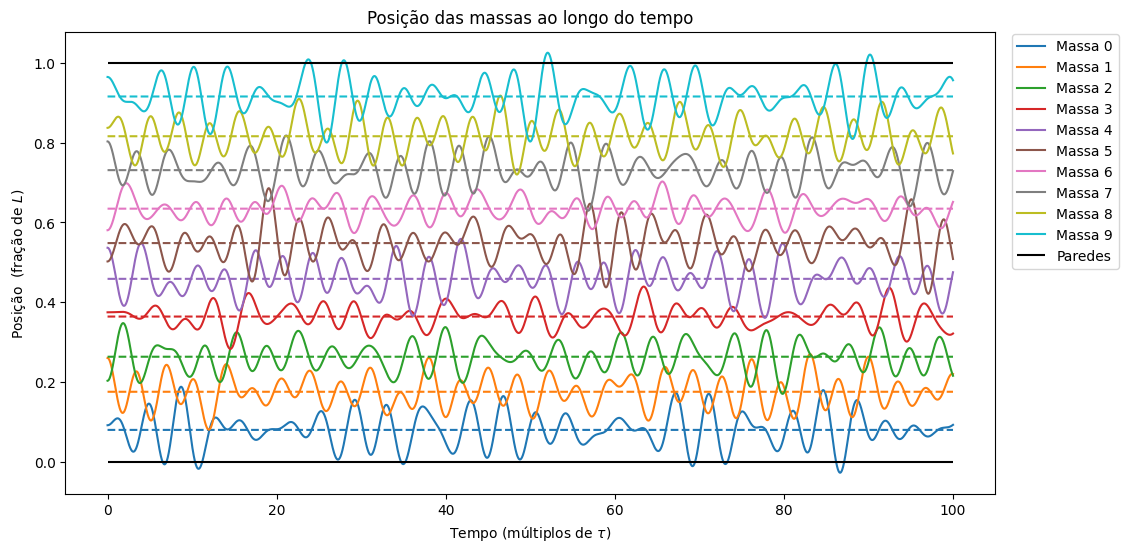

A tracejado vemos a posição de equilíbrio correspondente a cada massa.


In [8]:
# Parâmetros
N = 10

xi0 = np.random.uniform(-1/(N+1), 1/(N+1), N)

ki = np.random.normal(1, 0.1, N+1)
ki = ki / ki.mean()

t = np.linspace(0, 100, 5000)


# Obter as posições ao longo do tempo
X, dd = X_it(xi0, ki, t)

# Representar num gráfico x(t)
plt.figure(figsize=(12, 6))
for i in range(N):
    col = palete[i]
    plt.plot(t, X[i, :], color=col, label = f"Massa {i}")
    plt.plot(t, np.ones_like(t)*dd[i], color=col, linestyle="dashed")

plt.title("Posição das massas ao longo do tempo")
plt.ylabel("Posição  (fração de $L$)")
plt.xlabel("Tempo (múltiplos de $\\tau$)")

plt.hlines([0, 1], t[0], t[-1], colors=["black", "black"], label="Paredes")
plt.legend(bbox_to_anchor=(1.14, 1.01))
plt.show()

print("A tracejado vemos a posição de equilíbrio correspondente a cada massa.")

# Sistema de massas forçado
Considere o sistema de massas discutido na pergunta anterior e aplique
uma força na massa $l$ dada por, 
\begin{align*}
F_{l} & =Fe^{i\Omega t}\\
m\frac{d^{2}x_{i}}{dt^{2}} & =-k_{i}\left(x_{i}-x_{i-1}\right)+k_{i+1}\left(x_{i+1}-x_{i}\right)+\delta_{il}Fe^{i\Omega t-\gamma|t|}
\end{align*}

Fazendo a transformada de Fourier, desta equação obtemos 
\begin{equation}
-m\omega^{2}x_{i}(\omega)=-k_{i}\left(x_{i}(\omega)-x_{i-1}(\omega)\right)+k_{i+1}\left(x_{i+1}(\omega)-x_{i}(\omega)\right)+\frac{2\gamma F}{\gamma^{2}+(\omega-\Omega)^{2}}\delta_{il}
\end{equation}
onde para cada $\Omega$ obtemos uma solução $x_{i}(\omega)$. Analisando,
apenas para $\omega=\Omega$ e considerando $\tilde{F}=2F/\gamma$

1. Considerando o sistema aleatório com $N=10$ e $\tilde{F}=1$ e $l=1$, represente num gráfico com as ordenadas em escala logarítmica as soluções $|x_{i}(\Omega)|$ como função de $\Omega$. Todas as curvas têm os mesmos máximos?

## Equacionar o Problema

A equação (1) acima descreve um sistema de equações no domínio das frequências, que vamos resolver no caso em que $\omega = \Omega$. Ou seja, vamos determinar o valor da transformada de Fourier de $x_i(t)$ em $\omega = \Omega$, o que correspondente a estudar a contribuição do movimento de frequência $\Omega$ para o movimento total de $x_i(t)$.

Começamos por escrever:
- A equação (1) para $\omega = \Omega$, $m = 1$, $\tilde F = 1$ e $l = 1$ (os $k_i/m$ têm unidades de $\omega^2$):
$$
\begin{align*}
&\ -\Omega^{2}x_{i}(\Omega)=-k_{i}\left(x_{i}(\Omega)-x_{i-1}(\Omega)\right)+k_{i+1}\left(x_{i+1}(\Omega)-x_{i}(\Omega)\right)+\tilde F\delta_{il} \Leftrightarrow
\\[0.2cm]
\Leftrightarrow&\ k_{i}x_{i-1}(\Omega) - (k_i + k_{i+1} - \Omega^2)x_i(\Omega) + k_{i+1}x_{i+1}(\Omega) = -\delta_{i1}
\end{align*}
$$

- A transformada de Fourier de $x_0(t) = 0$:
$$
x_0(\omega) = 0
$$

- A transformada de Fourier de $x_{N+1}(t) = L$:
$$
x_{N+1}(\omega) = 2\pi L\delta(\omega)
$$

Então, notando que para $\Omega \ne 0$ as transformadas de Fourier de $x_0$ e $x_{N+1}$ são nulas, obtemos o seguinte sistema de equações:
$$
\begin{cases}
-(k_1 + k_2 - \Omega^2)x_1(\Omega) + k_{i+1}x_{i+1}(\Omega) = -1
\\[0.2cm]
\vdots
\\[0.2cm]
k_{i}x_{i-1}(\Omega) - (k_i + k_{i+1} - \Omega^2)x_i(\Omega) + k_{i+1}x_{i+1}(\Omega) = 0
\\[0.2cm]
\vdots
\\[0.2cm]
k_{N}x_{N-1}(\Omega) - (k_N + k_{N+1} - \Omega^2)x_N(\Omega) = 0
\end{cases}
$$

Na forma matricial temos então:
$$
\begin{pmatrix}
- k_1 - k_2 + \Omega^2 & k_2 & 0 & \dots& 0 & 0 & 0
\\[0.2cm]
k_2 & -k_2 - k_3 + \Omega^2 & k_3 & \dots& 0 & 0 & 0
\\[0.2cm]
0 & k_3 & -k_3 - k_4 + \Omega^2 & \dots& 0 & 0 & 0
\\[0.2cm]
\vdots & \vdots & \vdots & \ddots& \vdots& \vdots & \vdots
\\[0.2cm]
0 & 0 & 0 & \dots & -k_{N-2} - k_{N-1} + \Omega^2 & k_{N-1} & 0
\\[0.2cm]
0 & 0 & 0 & \dots & k_{N-1} & -k_{N-1} - k_N + \Omega^2 & k_{N}
\\[0.2cm]
0 & 0 & 0 & \dots & 0 & k_N & -k_{N} - k_{N+1} + \Omega^2
\end{pmatrix}
\begin{pmatrix}
x_1(\Omega)
\\[0.2cm]
x_2(\Omega)
\\[0.2cm]
x_3(\Omega)
\\[0.2cm]
\vdots
\\[0.2cm]
x_{N-2}(\Omega)
\\[0.2cm]
x_{N-1}(\Omega)
\\[0.2cm]
x_{N}(\Omega)
\\[0.2cm]
\end{pmatrix} =
\begin{pmatrix}
-1
\\[0.2cm]
0
\\[0.2cm]
0
\\[0.2cm]
\vdots
\\[0.2cm]
0
\\[0.2cm]
0
\\[0.2cm]
0
\\[0.2cm]
\end{pmatrix}
$$

Que podemos escrever como:

$$
A_\Omega X_i(\Omega) = b
$$

**Nota**: Vamos ainda definir a seguinte quantidade útil:
$$
\omega_\text{fundamental} = \frac{2\pi}{\tau}
$$

## Analisar os Resultados
Conseguimos observar 10 picos no gráfico de $|x_i(\Omega)|$! Estes picos correspondem a frequências que maximizam a resposta de cada massa, pelo que correspondem às frequências de ressonância do sistema!

Observam-se 10 frequências de ressonância que correspondem aos 10 graus de liberdade do sistema (um por cada massa, já que estas apenas se podem mover numa dimensão). Como o sistema tem 10 modos normais (um por cada grau de liberdade) deve ter frequências de ressonância junto de cada um destes modos normais.

Notamos ainda que após o 10º pico (para $\Omega$ maior que cerca de $2\omega_0$) o valor de $|x_i(\Omega)|$ começa a diminuir para todos os $x_i$, o que mostra que para $\Omega$ elevado o movimento das massas praticamente não tem componente com frequência $\Omega$. Isto faz sentido pois neste caso $\Omega$ está muito longe das frequências de ressonância do sistema.

Percebemos ainda que todas as curvas atingem máximos em abcissas sensivelmente iguais, sendo que o valor dos máximos varia muito de massa para massa. Isto é o comportamento esperado pois quando o sistema está num modo normal o movimento de uma dada massa ou está em fase ou está em antifase com o movimento das restantes massas. Como neste caso as frequências de ressonância coincidem com as frequências de modo normal, as massas também estão todas em fase ou em antifase para as frequências de ressonância, pelo observamos um máximo de $|x_i(\Omega)|$ para todas as massas para um mesmo valor de $\Omega$.

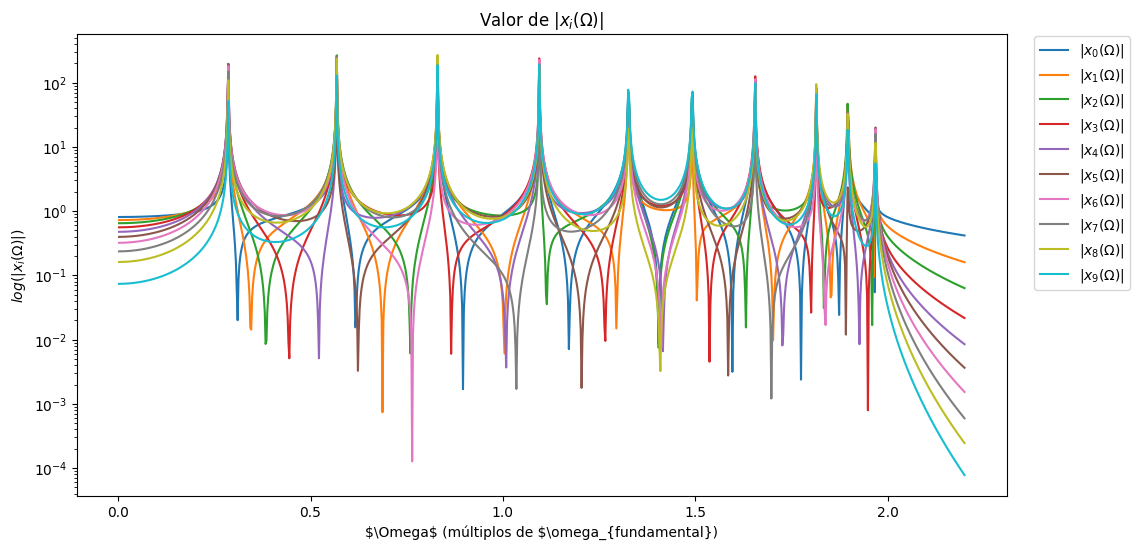

In [9]:
def eqs2(N: int, ki: np.ndarray, Omega: float) -> tuple[np.ndarray, np.ndarray]:
    """
        Devolve a matriz A e o vetor b que define o problema 2 na forma A * x = b.

        ### Argumentos
        N: Número de equações
        ki: Array com os valores de ki escolhidos
        Omega: Valor de Omega escolhido
    
        ### Retorno
        Ab: Matriz A em banda 3 por N (na forma descrita nas páginas 524-525 do Newman)
        bb: Vetor com N entradas
    """

    Ab, bb = eqs1(N, ki)
    Ab[1, :] += Omega**2

    bb = np.zeros_like(bb)
    bb[0] = -1
    bb[-1] = 0

    return Ab, bb


# Parâmetros
N = 10

# Descartar Omega = 0 e escolher a gama ideal para mostrar todos os picos
OO = np.linspace(0, 2.2, 1000)[1:] 

# Usar o ki da pergunta anterior (caso contrário descomentar o código abaixo)
# ki = np.random.normal(1, 0.1, N+1)
# ki /= ki.mean()

# Resultados
X = np.zeros((10, len(OO)))
for index, Omega in enumerate(OO):

    # Matriz do problema
    Ab, bb = eqs2(N, ki, Omega)
    A = unbandify(Ab, 1, 1)

    # Solução do problema
    xx = gausselim(A, bb)
    X[:, index] = abs(xx)

# Representar graficamente os resultados
plt.figure(figsize=(12, 6))
for i in range(N):
    col = palete[i]
    plt.plot(OO, X[i, :], color=col, label = f"$|x_{i}(\\Omega)|$")


plt.title("Valor de $|x_i(\\Omega)|$")
plt.xlabel("$\\Omega$ (múltiplos de $\\omega_{fundamental})")
plt.ylabel("$log(|x_i(\\Omega)|)$")
plt.yscale("log")

plt.legend(bbox_to_anchor=(1.14, 1.01))
plt.show()

2. Identifique na alínea anterior a posição dos valores próprios do sistema.

Como vimos na pergunta 1.4 (b) o movimento das massas no caso em que não há força externa é dado por:
$$
\begin{align*}
x_i(t) &= U_{i\beta}\left[U_{j\beta}x_j(0) \cos\left(t\sqrt{|\lambda_\beta|}\right)\right]
\end{align*}
$$

Ou seja, as frequências de modo normal do sistema são dadas por $\omega_\beta = \sqrt{|\lambda_\beta|}$, pois o movimento de cada massa é uma combinação linear de movimentos de frequências $\sqrt{|\lambda_\beta|}$.

**Nota**: Os valores de $\lambda_\beta$ são os valores próprios de $A = A_0$.

## Analisar os Resultados
Como esperavamos, as frequências de modo normal do sistema correspondem às frequências de ressonância uma vez que não há amortecimento!

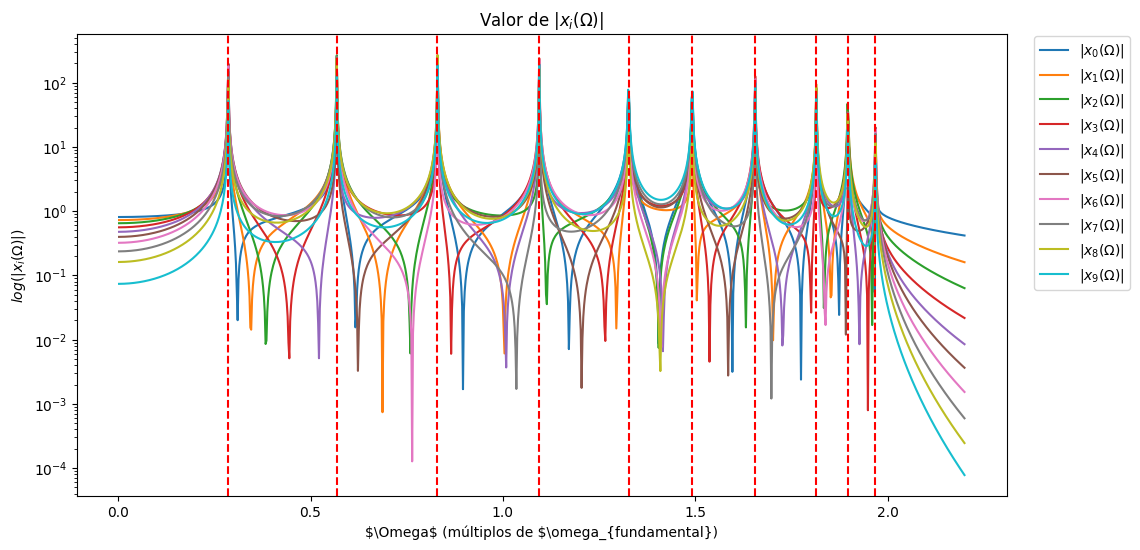

In [10]:
# Determinar autovalores da matriz que descreve o problema
Ab, bb = eqs1(N, ki)
A = unbandify(Ab, 1, 1)
lamb, U = eigenfinder(A)
oo = np.sqrt(abs(lamb))


# Representar graficamente os resultados
plt.figure(figsize=(12, 6))
for i in range(N):
    col = palete[i]
    plt.plot(OO, X[i, :], color=col, label = f"$|x_{i}(\\Omega)|$")


for omega in oo:
    plt.axvline(omega, color="red", linestyle="dashed")


plt.title("Valor de $|x_i(\\Omega)|$")
plt.xlabel("$\\Omega$ (múltiplos de $\\omega_{fundamental})")
plt.ylabel("$log(|x_i(\\Omega)|)$")
plt.yscale("log")

plt.legend(bbox_to_anchor=(1.14, 1.01))
plt.show()

3.  Escolha algumas das frequências onde existem os picos e as respectivas soluções $x_{i}$. Para cada uma das soluções escolhidas, normalize-a e transforme as suas coordenadas calculando,
\begin{equation}
f_{\beta}=U_{\beta i}^{T}x_{i}.
\end{equation}
Represente cada um dos $\left|f_{\beta}\right|$ que obteve. Que conclusões pode tirar?

As coordenadas $f_\beta$ coorespondem às coordenadas normais do sistema, pelo que cada uma tem uma frequência de modo normal do sistema associada. Nomeadamente, $f_\beta$ corresponde à frequência de oscilação $|\sqrt{\lambda_\beta}|$.

No gráfico abaixo chamamos $\omega_\beta$ a $|\sqrt{\lambda_\beta}|$.

## Analisar os Resultados
Ao obter os valores e vetores próprios de A certificamo-nos que o $i$-ésimo valor próprio corresponde ao vetor próprio guardado na $i$-ésima coluna de $U$. Deste modo, os resultados obtidos fazem sentido, na medida que para uma frequência de modo normal apenas uma das coordenadas de modo normal é que está animada de movimento.

Em particular, quando o sistema é excitado pela frequência de modo normal $\omega_\alpha$ apenas a coordenada normal $f_\alpha$ é que é não nula!

Mais ainda, como $U$ é ortogonal então a norma de $f_\beta$ será igual à norma de $x_i$ e como normalizamos $x_i$ temos que $\|f_\beta\| = 1$. Juntando esta condição ao que foi descrito anteiormente, percebemos que para a frequência de modo normal $\omega_\alpha$ temos $f_\beta = \delta_{\alpha\beta}$.

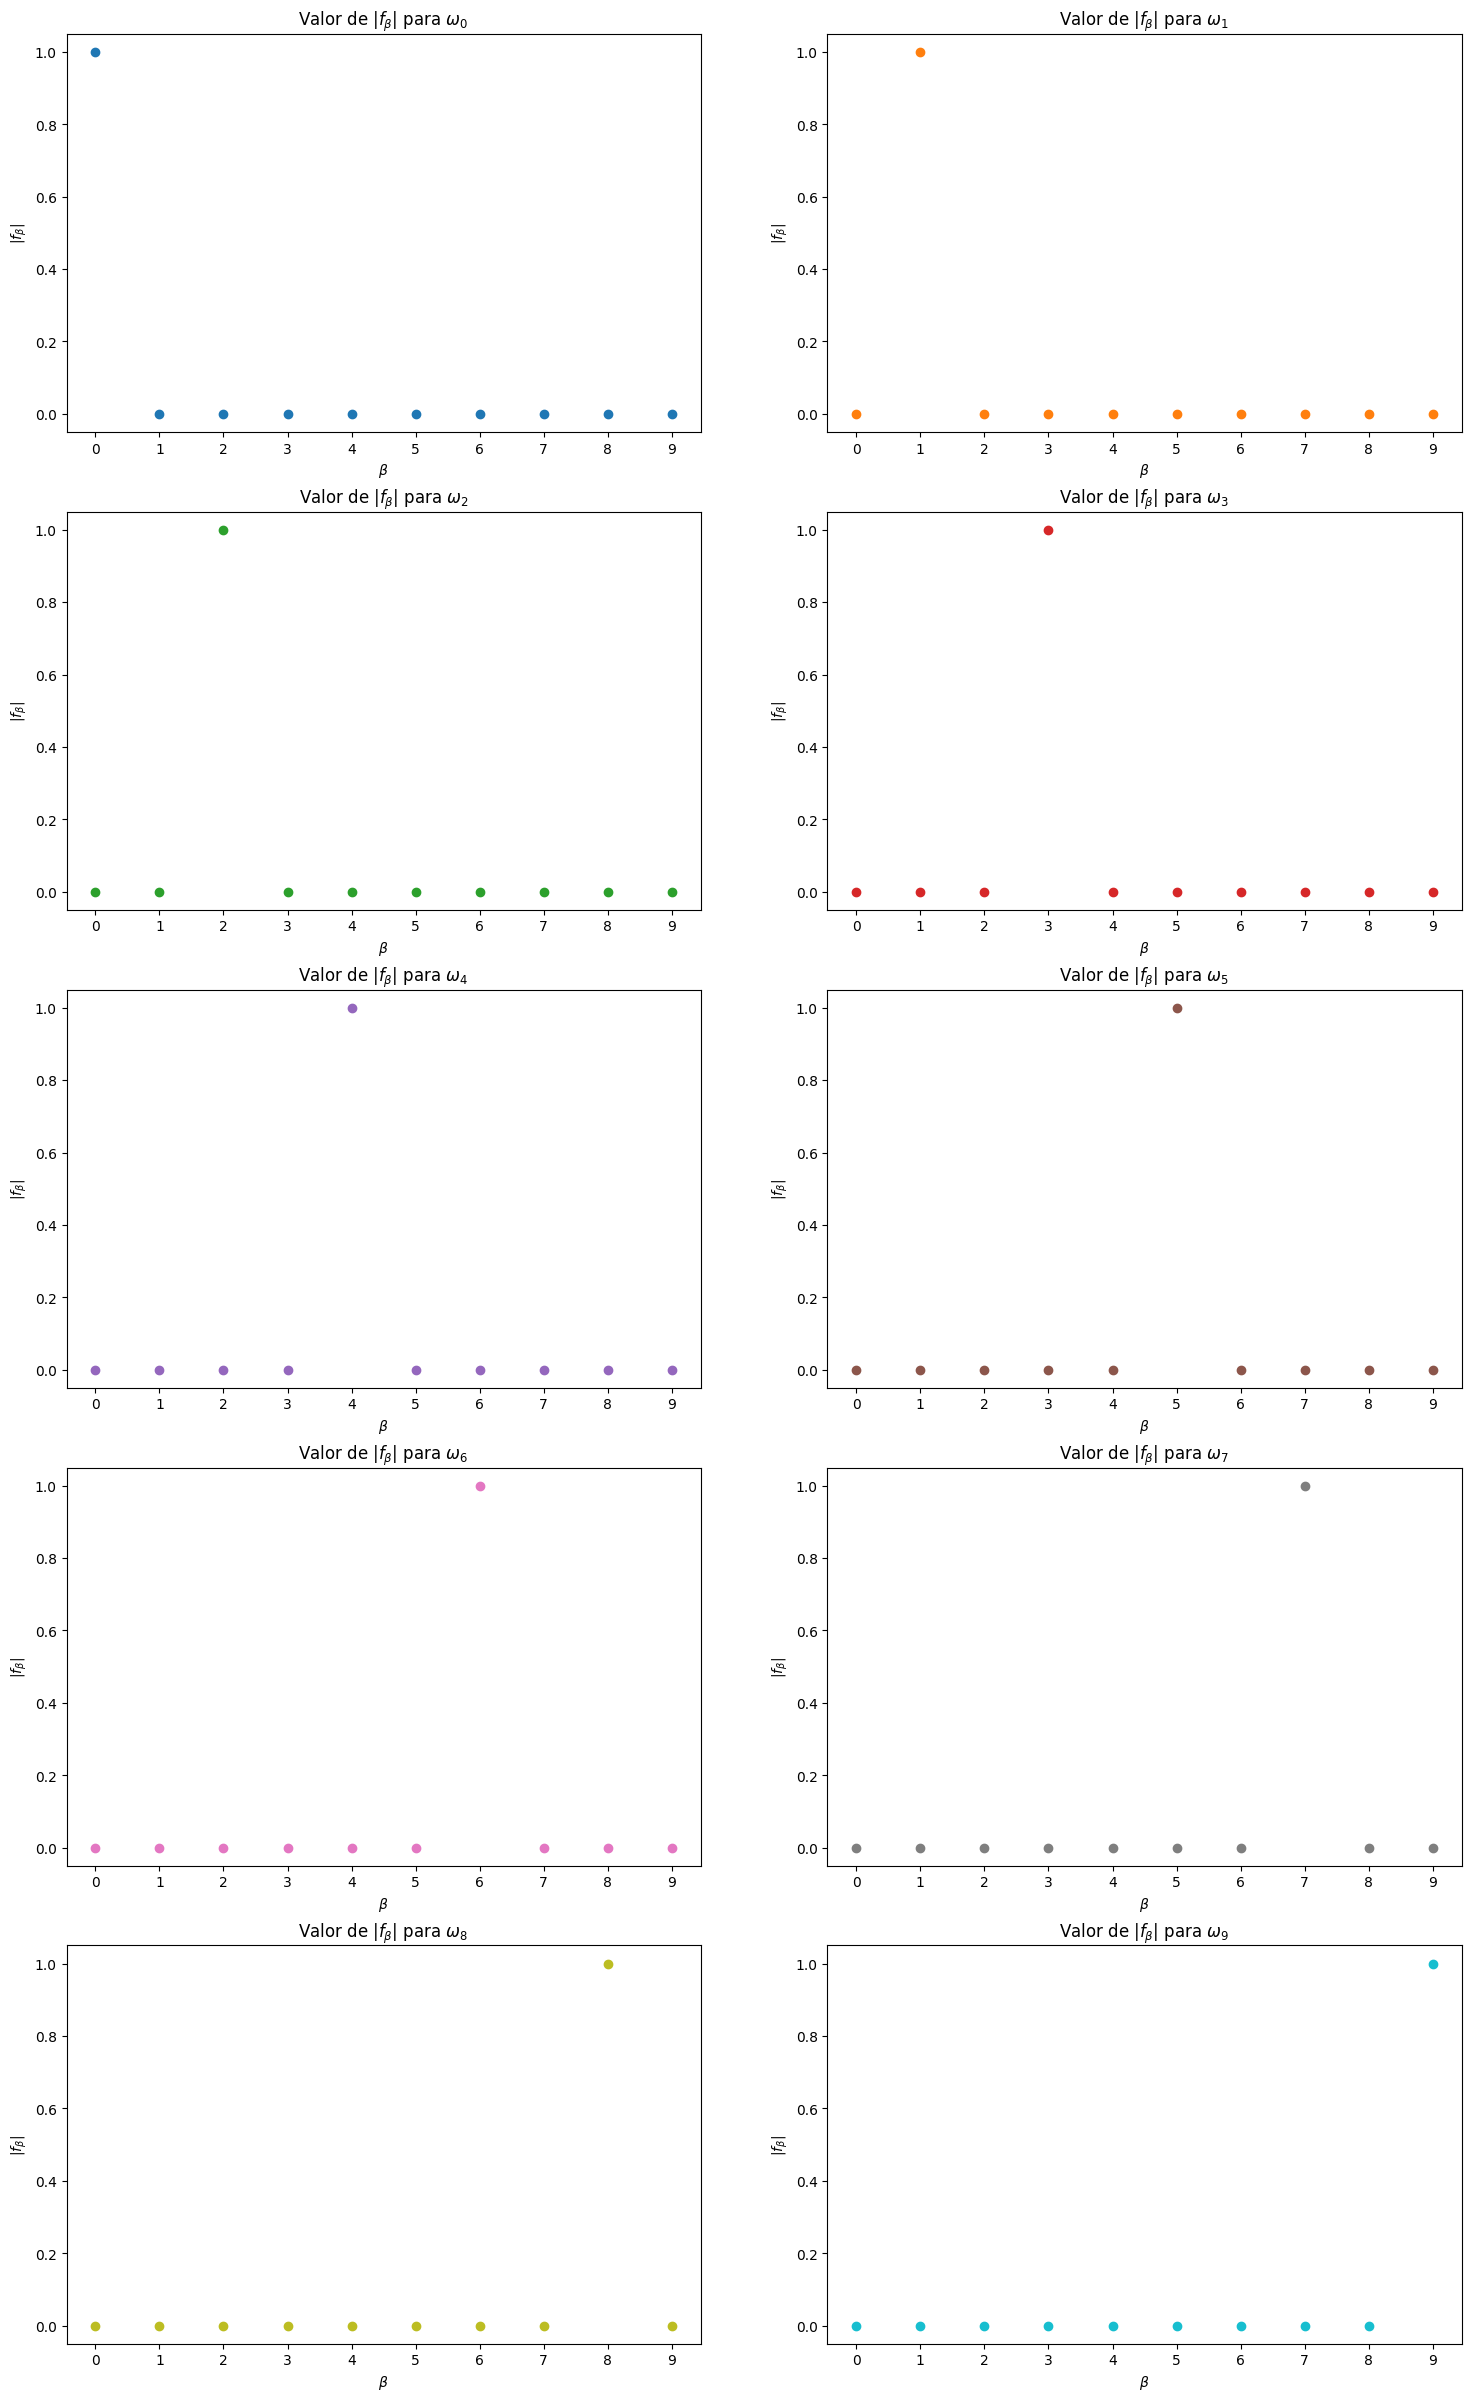

In [11]:
# Vamos usar todas as frequências
plt.figure(figsize=(18, 30))
for index, omega in enumerate(oo):
    # Obter equações
    Ab, bb = eqs2(N, ki, omega)
    A = unbandify(Ab, 1, 1)

    # Soluções x_i(Omega)
    xx = gausselim(A, bb)

    # Valores de f_beta
    ff = (U.T) @ (xx / np.linalg.norm(xx))


    # Representar graficamente os resultados
    col = palete[index]
    plt.subplot(N//2, 2, index+1)
    plt.scatter(np.arange(N), np.abs(ff), color=col)

    plt.xticks(np.arange(N), np.arange(N))
    plt.title(f"Valor de $|f_\\beta|$ para $\\omega_{index}$")
    plt.ylabel("$|f_\\beta|$")
    plt.xlabel("$\\beta$")

plt.show()

4. Repita o procedimento anterior adicionando uma outra força para $i=10$ mas com amplitude $\tilde{F}=-1$ na equação da transformada de Fourier (mantemos a força em $l=1$). O que observa? 

## Equacionar o Problema
A equação que vimos no início da alínea 2.1 passa para:
$$
k_{i}x_{i-1}(\Omega) - (k_i + k_{i+1} - \Omega^2)x_i(\Omega) + k_{i+1}x_{i+1}(\Omega) = -\delta_{i\ 1} + \delta_{i\ 10}
$$

Na forma matricial temos então:
$$
\begin{pmatrix}
- k_1 - k_2 + \Omega^2 & k_2 & 0 & \dots& 0 & 0 & 0
\\[0.2cm]
k_2 & -k_2 - k_3 + \Omega^2 & k_3 & \dots& 0 & 0 & 0
\\[0.2cm]
0 & k_3 & -k_3 - k_4 + \Omega^2 & \dots& 0 & 0 & 0
\\[0.2cm]
\vdots & \vdots & \vdots & \ddots& \vdots& \vdots & \vdots
\\[0.2cm]
0 & 0 & 0 & \dots & -k_{N-2} - k_{N-1} + \Omega^2 & k_{N-1} & 0
\\[0.2cm]
0 & 0 & 0 & \dots & k_{N-1} & -k_{N-1} - k_N + \Omega^2 & k_{N}
\\[0.2cm]
0 & 0 & 0 & \dots & 0 & k_N & -k_{N} - k_{N+1} + \Omega^2
\end{pmatrix}
\begin{pmatrix}
x_1(\Omega)
\\[0.2cm]
x_2(\Omega)
\\[0.2cm]
x_3(\Omega)
\\[0.2cm]
\vdots
\\[0.2cm]
x_{N-2}(\Omega)
\\[0.2cm]
x_{N-1}(\Omega)
\\[0.2cm]
x_{N}(\Omega)
\\[0.2cm]
\end{pmatrix} =
\begin{pmatrix}
-1
\\[0.2cm]
0
\\[0.2cm]
0
\\[0.2cm]
\vdots
\\[0.2cm]
0
\\[0.2cm]
0
\\[0.2cm]
1
\\[0.2cm]
\end{pmatrix}
$$

## Analisar os Resultados
Adicionando esta outra força, obtemos resultados muito semelhantes. Isto é o comportamento esperado pois:
- Ambas as forças têm a mesma frequência.
- As frequências de ressonância do sistema são as mesmas nos dois casos.

Logo, obtemos picos de $|x_i(\Omega)|$ para as mesmas frequências quer neste caso quer no caso do início do problema 2, sendo que o valor desses picos altera-se! Ou seja, apenar de o sistema entrar em ressonância para as mesmas frequências, a amplitude dos diferentes modos normais varia, como podemos ver comparando o primeiro gráfico abaixo com o gráfico do exercício 2.1.

Também poderiamos ver essa diferença de amplitudes no gráfico de $|f_\beta|$, mas não o fazemos pois $|f_\beta|$ está normalizado!

Alínea 2.1


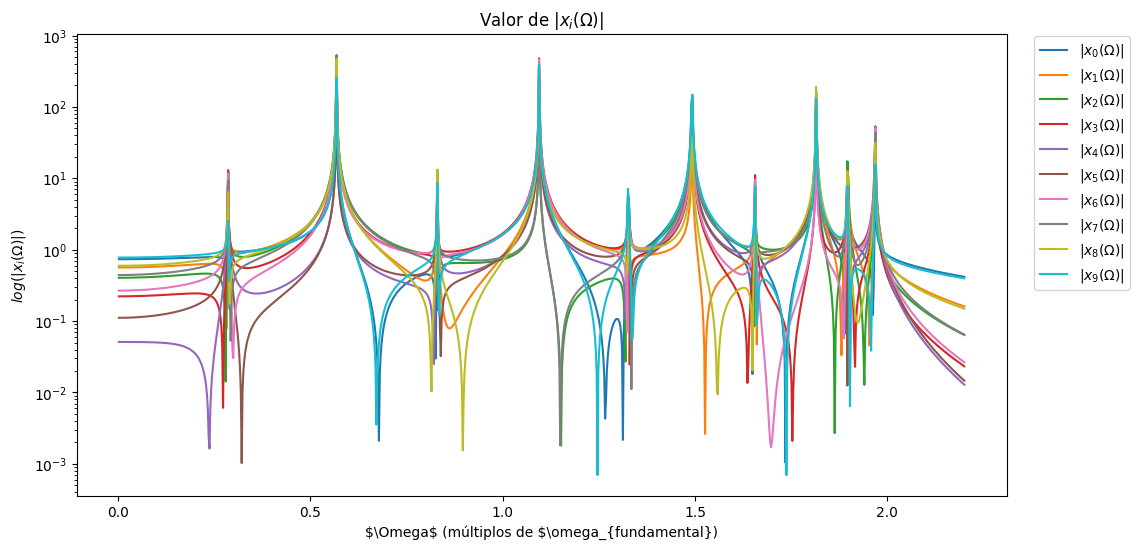

Alínea 2.2


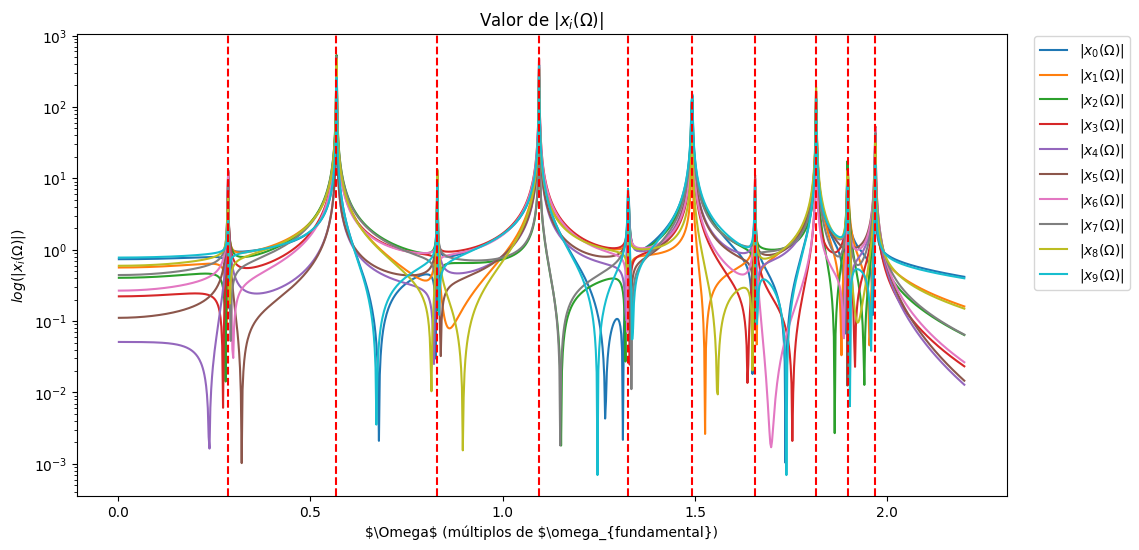

Alínea 2.3


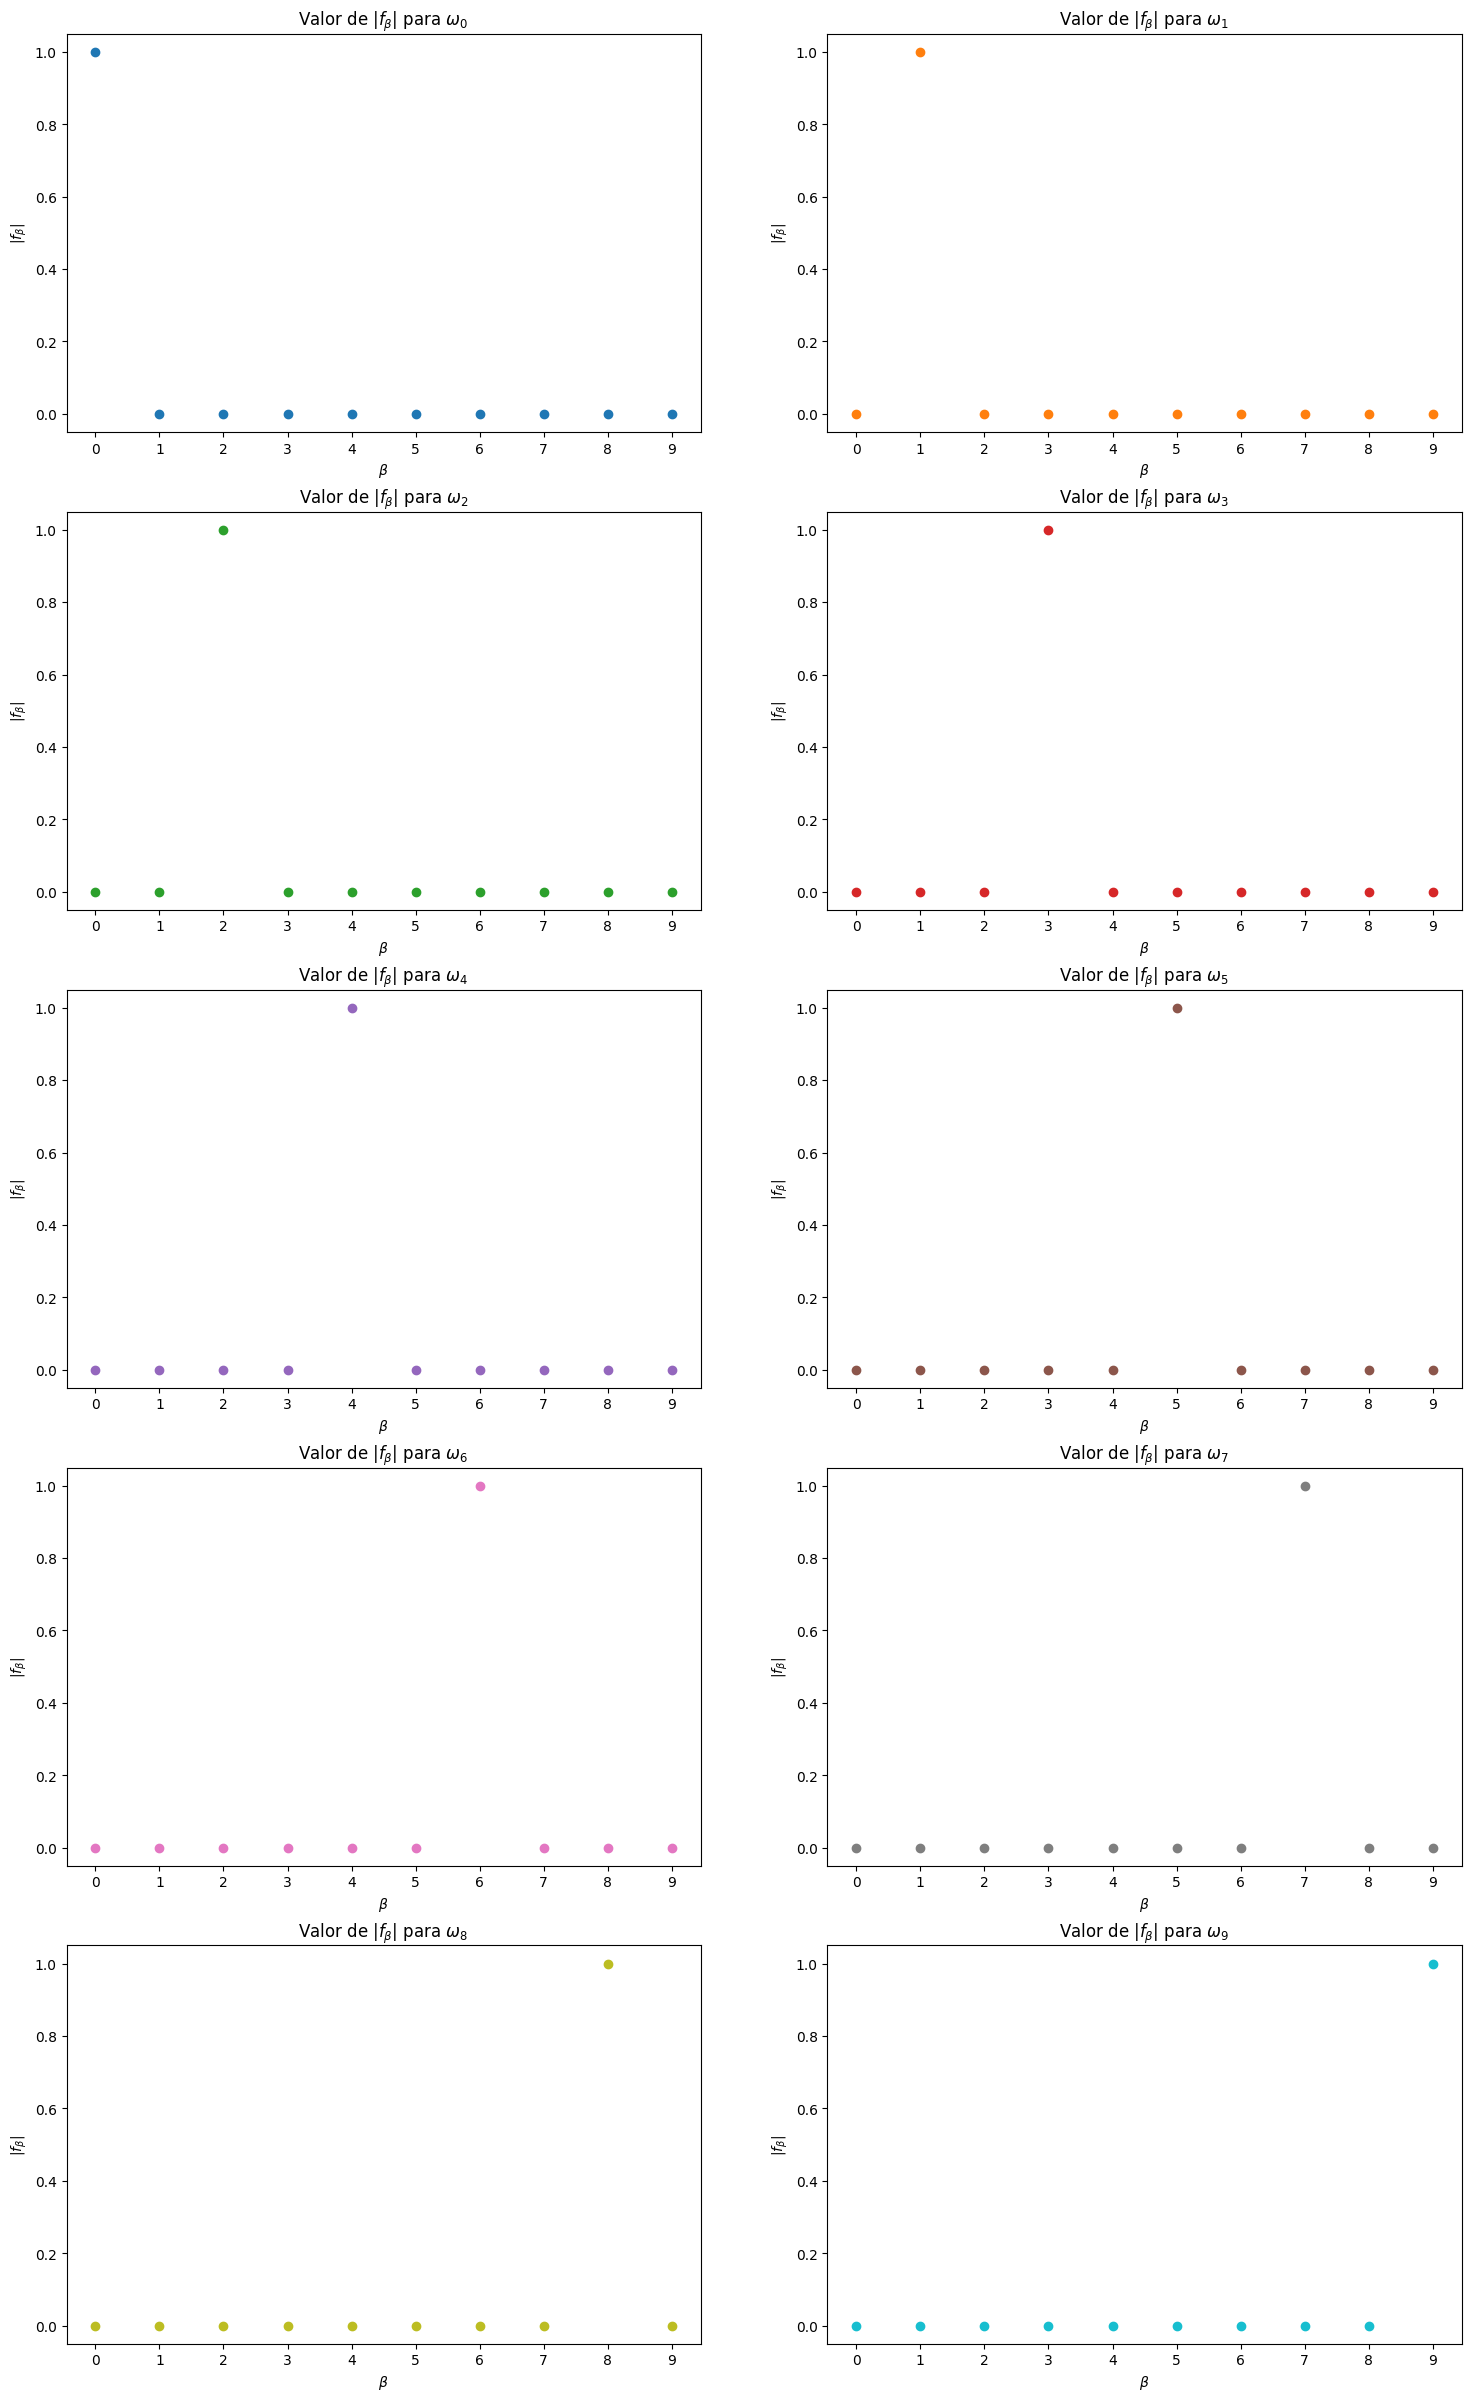

In [12]:
def eqs24(N: int, ki: np.ndarray, Omega: float) -> tuple[np.ndarray, np.ndarray]:
    """
        Devolve a matriz A e o vetor b que define o problema 2.4 na forma A * x = b.

        ### Argumentos
        N: Número de equações
        ki: Array com os valores de ki escolhidos
        Omega: Valor de Omega escolhido
    
        ### Retorno
        Ab: Matriz A em banda 3 por N (na forma descrita nas páginas 524-525 do Newman)
        bb: Vetor com N entradas
    """

    Ab, bb = eqs2(N, ki, Omega)
    bb[-1] = 1

    return Ab, bb


# FAZER 2.1 PARA ESTE CASO
print("Alínea 2.1")

# Resultados
X = np.zeros((10, len(OO)))
for index, Omega in enumerate(OO):

    # Matriz do problema
    Ab, bb = eqs24(N, ki, Omega)
    A = unbandify(Ab, 1, 1)

    # Solução do problema
    xx = gausselim(A, bb)
    X[:, index] = abs(xx)

# Representar graficamente os resultados
plt.figure(figsize=(12, 6))
for i in range(N):
    col = palete[i]
    plt.plot(OO, X[i, :], color=col, label = f"$|x_{i}(\\Omega)|$")


plt.title("Valor de $|x_i(\\Omega)|$")
plt.xlabel("$\\Omega$ (múltiplos de $\\omega_{fundamental})")
plt.ylabel("$log(|x_i(\\Omega)|)$")
plt.yscale("log")

plt.legend(bbox_to_anchor=(1.14, 1.01))
plt.show()



# FAZER 2.2 PARA ESTE CASO
print("Alínea 2.2")

# Determinar autovalores da matriz que descreve o problema
Ab, bb = eqs1(N, ki)
A = unbandify(Ab, 1, 1)
lamb, U = eigenfinder(A)
oo = np.sqrt(abs(lamb))


# Representar graficamente os resultados
plt.figure(figsize=(12, 6))
for i in range(N):
    col = palete[i]
    plt.plot(OO, X[i, :], color=col, label = f"$|x_{i}(\\Omega)|$")


for omega in oo:
    plt.axvline(omega, color="red", linestyle="dashed")


plt.title("Valor de $|x_i(\\Omega)|$")
plt.xlabel("$\\Omega$ (múltiplos de $\\omega_{fundamental})")
plt.ylabel("$log(|x_i(\\Omega)|)$")
plt.yscale("log")

plt.legend(bbox_to_anchor=(1.14, 1.01))
plt.show()



# FAZER 2.3 PARA ESTE CASO
print("Alínea 2.3")

# Vamos usar todas as frequências
plt.figure(figsize=(18, 30))
for index, omega in enumerate(oo):
    # Obter equações
    Ab, bb = eqs24(N, ki, omega)
    A = unbandify(Ab, 1, 1)

    # Soluções x_i(Omega)
    xx = gausselim(A, bb)

    # Valores de f_beta
    ff = (U.T) @ (xx / np.linalg.norm(xx))


    # Representar graficamente os resultados
    col = palete[index]
    plt.subplot(N//2, 2, index+1)
    plt.scatter(np.arange(N), np.abs(ff), color=col)

    plt.xticks(np.arange(N), np.arange(N))
    plt.title(f"Valor de $|f_\\beta|$ para $\\omega_{index}$")
    plt.ylabel("$|f_\\beta|$")
    plt.xlabel("$\\beta$")

plt.show()

Bom Trabalho